# FORECASTING

Once the Exploratory Data Analysis is complete, it would be possible to advance into the selection of a proper model to deliver the forecasting.

Let's start with the linear models, models which are related to linear regression but consider the correlation between diferent points in time.

 - Autoregressive Models
 - Moving Average Models
 - Autoregressive Integrated Moving Average Models
 - Vectorial Autoregression Models
 - Hierarquical Models

## AutoRegressive Model (AR)

 - Past values have an effect on current values
 - The order of the AR model corresponds to the number of days incorporated

$$y_t = \beta_1y_{t-1} + \beta_2y_{t-2} + \beta_3y_{t-3} + \cdots + \beta_py_{t-p}$$

## Moving Average Model (MA)

 - The value of the dependent variable ($y_t$) depends on the previos days error terms

$$y_t = \varepsilon_t + \alpha_1\varepsilon_{t-1} + \alpha_2\varepsilon_{t-2} + \cdots \alpha_q\varepsilon_{t-q}$$

or

$$X_t = \mu +\varepsilon_t + \theta_1\varepsilon_{t-1} + \cdots + \theta_q\varepsilon_{t-q}$$

 - $\mu$: mean of series
 - $\theta_1, \cdots , \theta_q$: parameters
 - $\varepsilon_t, \varepsilon_{t-1}, \varepsilon_{t-q}$: white noise error terms
 - $q$: order of the MA model

## Auto Regressive Moving Average (ARMA)

 - Combination of AR and MA
 
$$y_t = \beta_1y_{t-1} + \beta_2y_{t-2} + \beta_3y_{t-3} + \cdots + \beta_py_{t-p} + \varepsilon_t + \alpha_1\varepsilon_{t-1} + \alpha_2\varepsilon_{t-2} + \cdots \alpha_q\varepsilon_{t-q}$$

## AutoRegressive Integrated Moving Average Model (ARIMA)

 - Also called Box-Jenkins
 - Adds differencing to the ARMA model
 - Subtracts the current value from the previous one, transforming a non-stationary time-series into a stationary one.
 
   - First Order Diferencing: addresses linear trends
   $$z_i = y_i - y_{i-1}$$
   - Second Order Diferencing: addesses quadratic trends
   $$z_i = (y_i - y_{i-1}) - (y_{i-1} - y_{i-2})$$
   
Three parameters define the model:

 - $p$: Number of autoregressive terms (AR Order)
 - $d$: Number of nonseasonal differences (Differencing Order)
 - $q$: Number of moving-average terms (MA Order)

## Obtaining the parameters

In order to obtain the correct terms. There are a few important functions to use:

### Auto Correlation Function (ACF)
 - Correlation between observations of the current point in time and the observations at **all previous points in time**
 - Determine the **optimal number of MA terms**
 
 ### Partial Auto Correlation Function (PACF)
 - Correlation between observations made at **two points in time**
 - Accounts for any influence from other data points
 - Determine the **optimal number of AR terms**
 - The number of terms used determines the order of the model

## Loading the desired dataset

Before jumping into the models:

 - Select the appropriate period
 - Load the object informations
 - Prepare the Training and Testsets

In [1]:
from main import load_tower

In [2]:
period = 'd'
Tower = load_tower(pickefile='UT001.pkl')

## Modelagem

Devemos considerar agora a relevância dos horizontes de previsão. Dentro do contexto de previsão de geração de energia elétrica, existem diferentes usos para diferentes horizontes de previsão do recurso. A tabela abaixo indica alguns desses horizontes:

|  **Escala** |      **Horizonte**      |                            **Aplicação**                            |
|:-----------:|:-----------------------:|:-------------------------------------------------------------------:|
| imediata    | até 8 horas             | Operações de rede, ações de regulação                               |
| curto-prazo | dia à frente            | Planejamento de despacho econômico, segurança de mercado de energia |
| longo-prazo | múltiplos dias à frente | Planejamento de manutenção, planejamento da operação                |

Considerando a tabela, a modelagem abaixo visa obter informações relevantes para decisões de curto-prazo, desta forma, dentro de um horizonte diário.

### Separação em Treino e Teste

Considerando então o horizonte de relevância de curto-prazo, foi separado um modelo de teste e treino considerando a previsão de dois dias a frente.

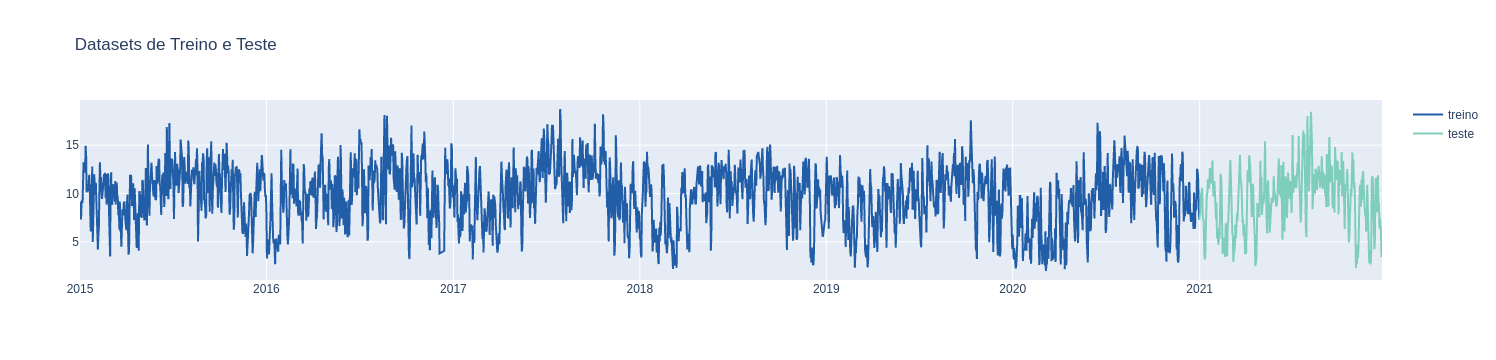

In [3]:
Tower.build_sets(period=period, split='2021-01-01', plot=True, export=False)

## Escolha de um modelo

A escolha de qualquer modelo depende fortemente dos testes estatísicos implementados na análise exploratória. Considerando o horizonte diário, temos o seguinte comportamento:

              Augmented Dickey-Fuller Test               
                          DAILY                          
---------------------------------------------------------
Estatística ADF:
-5.483883443739295
---------------------------------------------------------
p-valor:
2.2525050461455363e-06
---------------------------------------------------------
lags utilizados:
21
---------------------------------------------------------
N observações utilizadas:
2518
Valores Críticos:
	1%: -3.432949673919829
	5%: -2.8626885257380397
	10%: -2.5673814041175183
---------------------------------------------------------
Hipótese Nula Rejeitada? - True
Série Temporal ESTACIONÁRIA


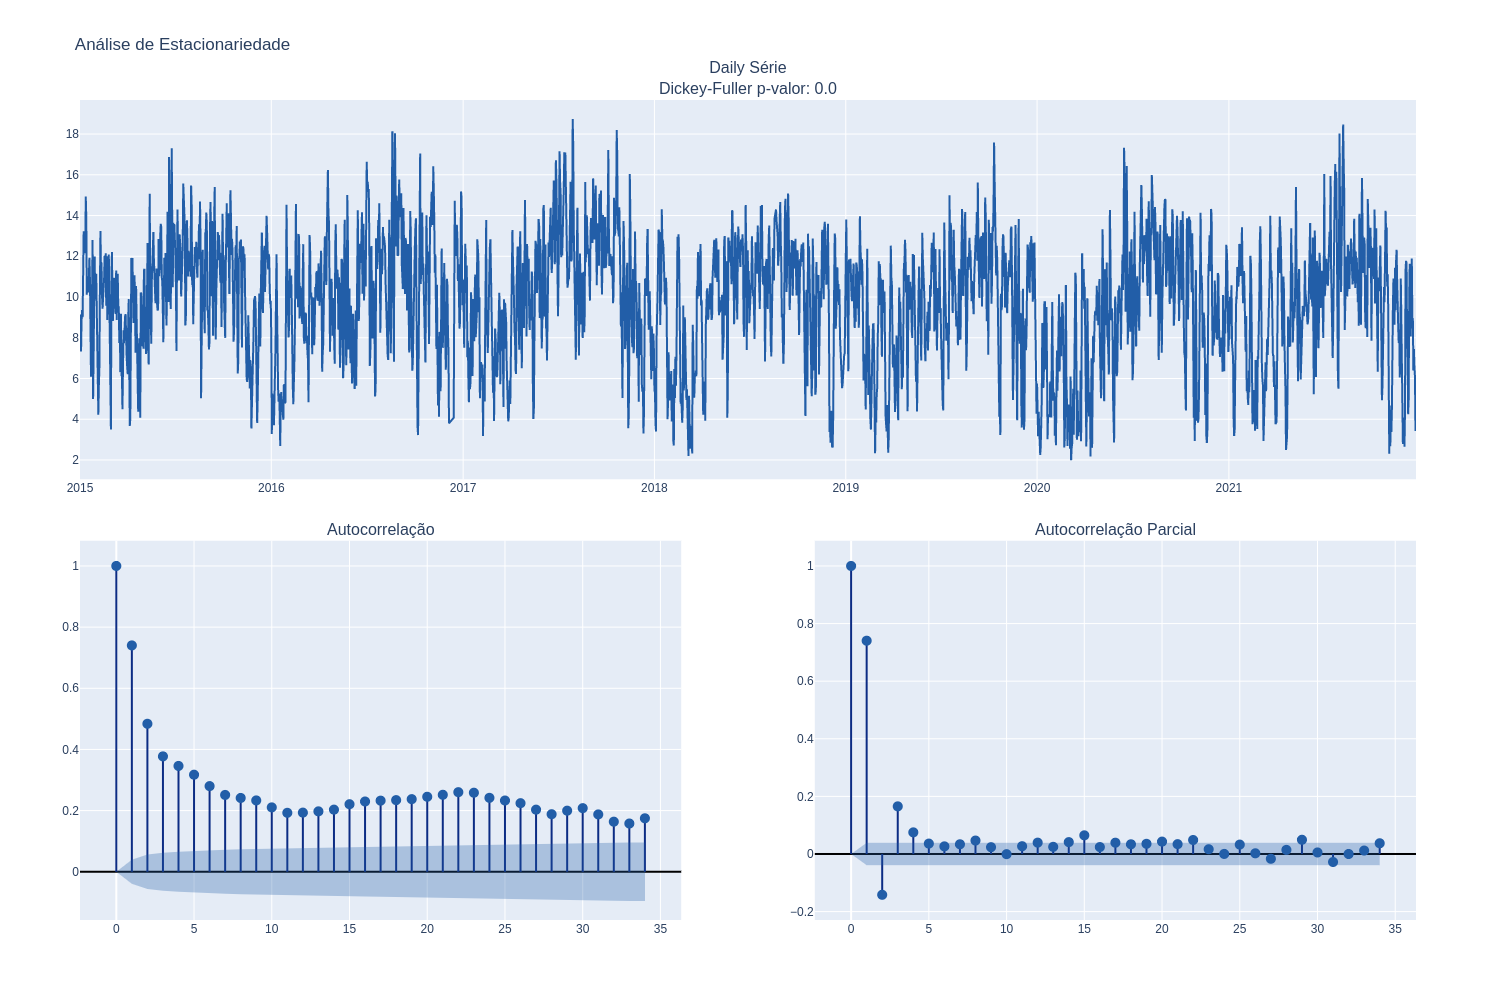

In [4]:
Tower.stationarity(period=period, plot=True, verbose=True, export=False)

Observa-se que, apesar de estacionária, a série possui um autocorrelação significativa. Note também que não existe um período típico para as autocorrelações e é muito provável que uma diferenciação de primeira ordem seja suficiente para reduzir esse comportamento.

Abaixo a mesma análise de estacionariedade para um lag de 1 dia.

              Augmented Dickey-Fuller Test               
                          DAILY                          
---------------------------------------------------------
Estatística ADF:
-28.008226871035475
---------------------------------------------------------
p-valor:
0.0
---------------------------------------------------------
lags utilizados:
3
---------------------------------------------------------
N observações utilizadas:
2536
Valores Críticos:
	1%: -3.432931203247706
	5%: -2.8626803690000653
	10%: -2.5673770613761207
---------------------------------------------------------
Hipótese Nula Rejeitada? - True
Série Temporal ESTACIONÁRIA


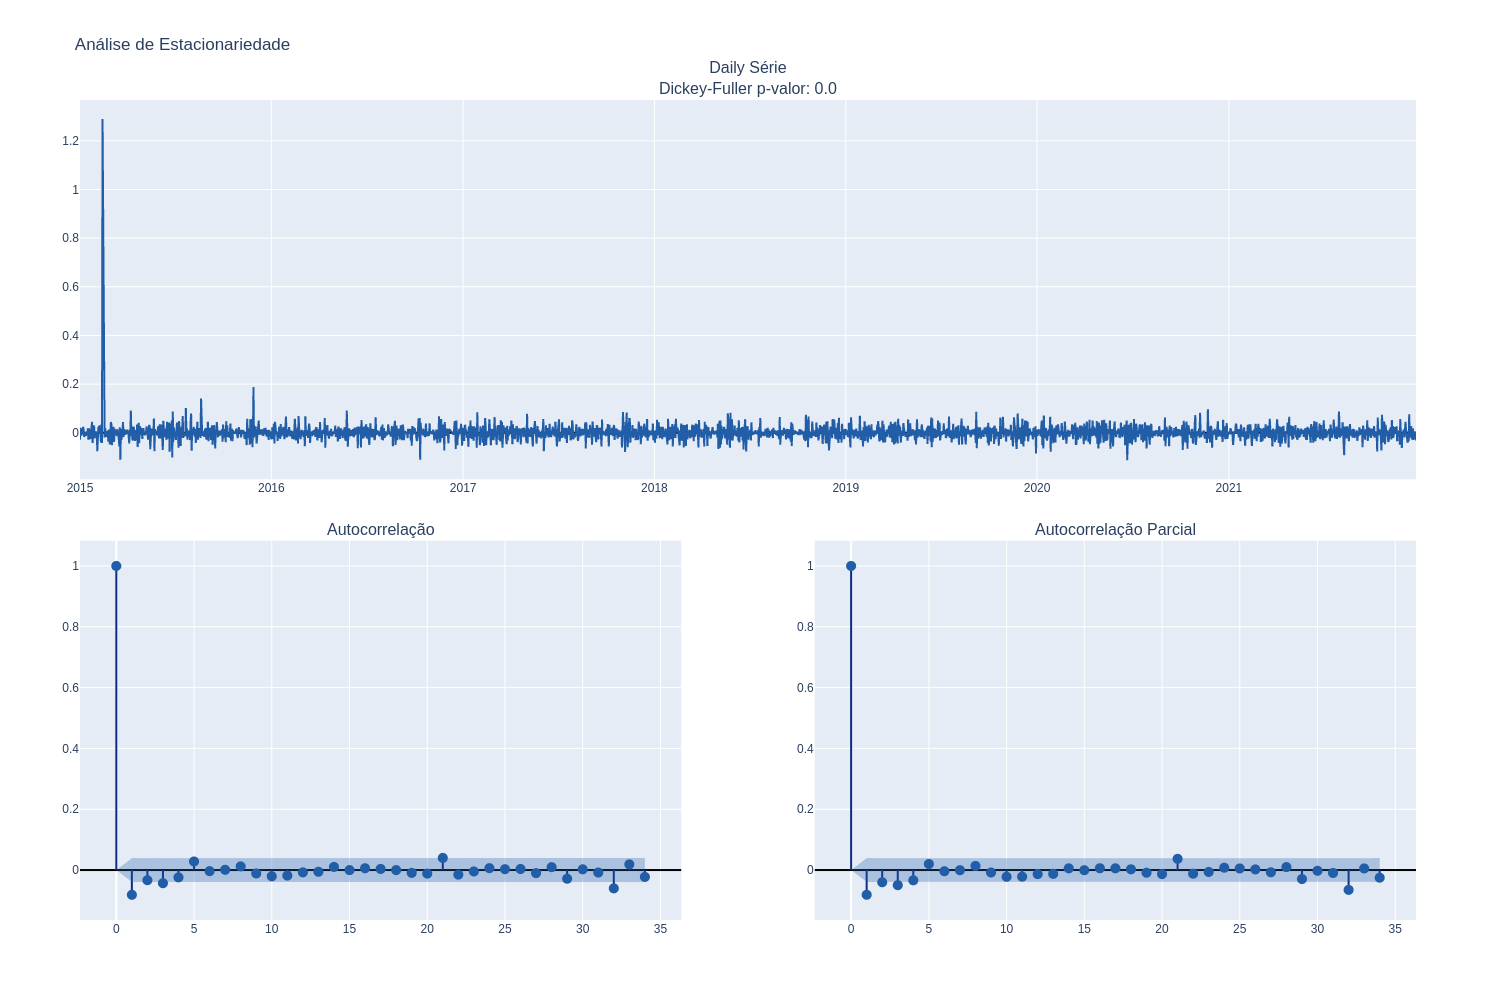

In [5]:
Tower.stationarity(period=period, plot=True, diff=1, verbose=True, export=False)

Isso indica que de fato existia uma forte correlação entre o a velocidade do vento do dia, com a velocidade no dia anterior.

Esses dados indicam que:

 - Série de observaçoes diárias é ESTACIONÁRIA
 - Existe uma forte correlação entre o dia anterior e o dia observado
 - A série possui um comportamento sasonal inerente à natureza do vento

Considerando então que um modelo SARIMA é um bom candidato como preditor temos:
 - A ordem $p$ é dada pelo lag imediatamente anterior aos valores de PACF cortarem o limite superior = 4
 - A ordem $d$ é dado pelo grau de diferenciação necessário para tornar a série estacionária, neste caso 1, considerando que, apesar de estacionária a série possuia um grau de autocorrelação muito forte
 - A ordem $q$ é dada pelo lag imediatamente anterior aos valores de ACF cortarem o limite superior = 4

## Forecast

In [6]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse as RMSE

In [11]:
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'



def forecast(dataset, train, test, verbose: bool=False):
    model = SARIMAX(dataset,order=(3, 1, 1),
                            seasonal_order=(3, 1, 1, 12),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    
    forecast = model.fit(disp=verbose)
    
    prediction = forecast.get_prediction(start=len(train),
                                         dynamic=False)
    
    results = pd.concat([prediction.predicted_mean, prediction.conf_int()], axis=1)
    results.columns = ['predicted', 'lower_ci', 'upper_ci']
    
    error = RMSE(test, prediction.predicted_mean)
    
    return {'data': results, 'error': error}

In [12]:
result = forecast(dataset=Tower.dataset['mean'],
                  train=Tower.trainset['mean'],
                  test=Tower.testset['mean'])

In [15]:
print('RMSE: {}'.format(result['error']))
result['data']

RMSE: 2.054398880938585


predicted  lower_ci   upper_ci
time                                      
2021-01-01   7.874715  3.939274  11.810156
2021-01-02   8.514056  4.578615  12.449497
2021-01-03   8.136221  4.200780  12.071661
2021-01-04  10.139276  6.203836  14.074716
2021-01-05   8.168742  4.233304  12.104179
...               ...       ...        ...
2021-12-20   6.524961  2.591040  10.458882
2021-12-21   8.234157  4.300261  12.168053
2021-12-22   6.815308  2.881419  10.749196
2021-12-23   6.683546  2.749659  10.617432
2021-12-24   4.715347  0.781462   8.649232

[358 rows x 3 columns]

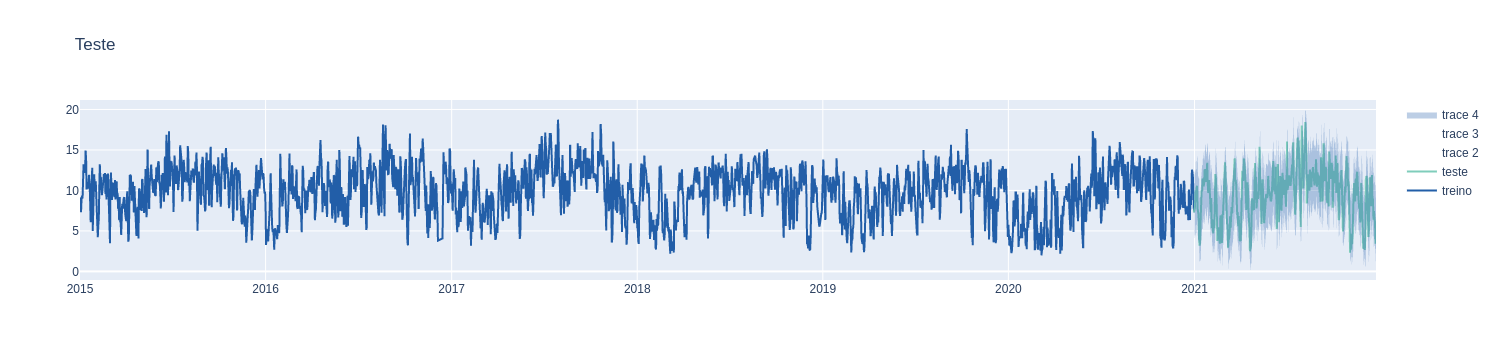

In [20]:
from services import theme

import plotly.graph_objs as go
color_list = theme.get_color_list()

# Train
train = go.Scatter(name='treino',
                   x=Tower.trainset.index,
                   y=Tower.trainset['mean'],
                   mode='lines',
                   line=dict(color=color_list[4]))

# Test
testset_plot = pd.concat([Tower.trainset.iloc[-1:], Tower.testset])
test = go.Scatter(name='teste',
                  x=testset_plot.index,
                  y=testset_plot['mean'],
                  mode='lines',
                  line=dict(color=color_list[1]))

# Forecast
forecast_line = go.Scatter(x=result['data'].index,
                           y=result['data']['predicted'],
                           mode='lines',
                           line_color='rgba(255,255,255,0)')
forecast_upper = go.Scatter(x=result['data'].index,
                            y=result['data']['upper_ci'],
                            mode='lines',
                            line_color='rgba(255,255,255,0)')
forecast_lower = go.Scatter(x=result['data'].index,
                            y=result['data']['lower_ci'], 
                            mode='lines',
                            fillcolor='rgba(34,94,168, 0.3)',
                            fill='tonexty',
                            line_color='rgba(255,255,255,0)')

fig = go.Figure()
fig.add_trace(train)
fig.add_trace(test)
fig.add_trace(forecast_line)
fig.add_trace(forecast_upper)
fig.add_trace(forecast_lower)
fig.update_layout(title_text='Teste',
                  xaxis_showticklabels=True)

fig.show()

In [ ]:
start_forecast = len(Tower.trainset)
pred = results.get_prediction(start=start_forecast,
                              dynamic=False)
pred_ci = pred.conf_int()

ax = Tower.dataset['mean'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predictions', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed')
plt.legend()

plt.show()

In [ ]:

import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
import yaml

from plotly.subplots import make_subplots

from services import (translation, theme, timeseries)

color_list = theme.get_color_list()

def plot_forecast(train, test, forecast):
    train_trace = go.Scatter(
                name='Treino',
                x=train.index,
                y=train['mean'],
                mode='lines',
                line=dict(color=color_list[5]))

    #Appends last element of training to connect line
    test_df = train.iloc[-1:].append(test)    
    test_trace = go.Scatter(
                name='Teste',
                x=test_df.index,
                y=test_df['mean'],
                mode='lines',
                line=dict(color=color_list[3]))

    forecast_trace = go.Scatter(
                name='Predição',
                x=forecast.index,
                y=forecast,
                mode='lines',
                opacity= 0.6,
                line=dict(color=color_list[1]))

    fig = go.Figure()
    fig.add_trace(train_trace)
    fig.add_trace(test_trace)
    fig.add_trace(forecast_trace)
    fig.update_layout(title_text='Forecast',
                        xaxis_showticklabels=True)

    fig.show()

plot_forecast(Tower.trainset, Tower.testset, pred.predicted_mean)

In [ ]:
from statsmodels.tools.eval_measures import rmse
error=rmse(Tower.testset['mean'], pred.predicted_mean)
error

In [ ]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(Tower.trainset['mean'],
 start_p=1, start_q=1, 
 max_p=4, max_q=4, 
 d=1, max_d=12,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

In [ ]:
step_wise.summary()